In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import joblib

In [3]:
car_data=pd.read_csv('/kaggle/input/uber-lyft-cab-prices/cab_rides.csv')

In [4]:
car_data.shape

(693071, 10)

In [5]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [6]:
print(f"Memory usage by Car Ride Dataset: {round(car_data.memory_usage().sum()/1024**2,2)} MB")

Memory usage by Car Ride Dataset: 52.88 MB


In [7]:
car_data['Date-Time']=pd.to_datetime(car_data.time_stamp)

In [8]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   distance          693071 non-null  float64       
 1   cab_type          693071 non-null  object        
 2   time_stamp        693071 non-null  int64         
 3   destination       693071 non-null  object        
 4   source            693071 non-null  object        
 5   price             637976 non-null  float64       
 6   surge_multiplier  693071 non-null  float64       
 7   id                693071 non-null  object        
 8   product_id        693071 non-null  object        
 9   name              693071 non-null  object        
 10  Date-Time         693071 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 58.2+ MB


In [9]:
car_data['Time']=car_data['Date-Time'].dt.time

In [10]:
car_data['Date']=car_data['Date-Time'].dt.date

In [11]:
car_data['Hour']=car_data['Date-Time'].dt.hour

In [12]:
car_data.Date.unique()

array([datetime.date(1970, 1, 1)], dtype=object)

In [13]:
car_data.sample()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,Date-Time,Time,Date,Hour
200410,2.12,Lyft,1545151504033,Northeastern University,Theatre District,22.5,1.0,c26d81bc-20d3-4e58-9f34-757384472322,lyft_lux,Lux Black,1970-01-01 00:25:45.151504033,00:25:45.151504,1970-01-01,0


**Since all data of Uber is of sametime so we can't consider it.**

In [14]:
car_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'Date-Time', 'Time',
       'Date', 'Hour'],
      dtype='object')

**Also we only take the Uber's data so we also drop the *cab_type* column**

In [15]:
uber=car_data[car_data.cab_type=='Uber'].drop(['time_stamp','cab_type','Date-Time', 'Time','Date', 'Hour'],axis=1)

In [16]:
uber.head()

,distance,destination,source,price,surge_multiplier,id,product_id,name
12,1.11,West End,North End,12.0,1.0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL
13,1.11,West End,North End,16.0,1.0,23f145da-f0c1-4d1f-a184-496bc003a7db,6c84fd89-3f11-4782-9b50-97c468b19529,Black
14,1.11,West End,North End,7.5,1.0,357559cb-8c58-4278-a41a-e33b2e0997a3,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX
15,1.11,West End,North End,7.5,1.0,50ef1165-9d23-416c-a65c-18906207b295,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV
16,1.11,West End,North End,26.0,1.0,91c4861c-1780-42b0-bca1-bbd64a422cc3,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV


In [17]:
uber.shape

(385663, 8)

In [18]:
uber.isnull().sum()

distance                0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [19]:
385663 - 55095

330568

**As we have lots of data and we have to predict the Price so we drop the missing values in the price column for convinience**

In [20]:
uber.dropna(inplace=True)

In [21]:
uber.isnull().sum()

distance            0
destination         0
source              0
price               0
surge_multiplier    0
id                  0
product_id          0
name                0
dtype: int64

In [22]:
uber.shape

(330568, 8)

In [23]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330568 entries, 12 to 693070
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          330568 non-null  float64
 1   destination       330568 non-null  object 
 2   source            330568 non-null  object 
 3   price             330568 non-null  float64
 4   surge_multiplier  330568 non-null  float64
 5   id                330568 non-null  object 
 6   product_id        330568 non-null  object 
 7   name              330568 non-null  object 
dtypes: float64(3), object(5)
memory usage: 22.7+ MB


In [24]:
print(f"Memory usage by Uber Ride Dataset: {round(uber.memory_usage().sum()/1024**2,2)} MB")

Memory usage by Uber Ride Dataset: 22.7 MB


In [25]:
categories=[]
for el in uber.columns:
    if uber[el].dtype=='object':
        categories.append(el)

In [26]:
categories #list of all columns have categorical data

['destination', 'source', 'id', 'product_id', 'name']

In [27]:
uber.nunique()

distance               422
destination             12
source                  12
price                  127
surge_multiplier         1
id                  330568
product_id               6
name                     6
dtype: int64

**Since all id's are unique so we don't have to encode the id column and we also have the option to make it the index column for the uber dataset**

In [28]:
# Categories to be Encoded are: Destination,Source,Product Id and Name
cat_encode=['destination','dource','product_id','name']

In [29]:
uber.destination.unique().sort()==uber.source.unique().sort()

True

The above cell shows that we have limited number of locations in the dataset.

In [30]:
uber.sample()

,distance,destination,source,price,surge_multiplier,id,product_id,name
87771,4.4,Financial District,Fenway,19.5,1.0,027b613c-c452-4546-8b92-1467ac88ec4b,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL


In [31]:
X=uber.drop(['price','id','surge_multiplier'],axis=1)
y=uber['price']

In [32]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,random_state=42)

In [33]:
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((247926, 5), (82642, 5), (247926,), (82642,))

In [34]:
X.sample()

,distance,destination,source,product_id,name
374728,1.16,West End,North End,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX


In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330568 entries, 12 to 693070
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   distance     330568 non-null  float64
 1   destination  330568 non-null  object 
 2   source       330568 non-null  object 
 3   product_id   330568 non-null  object 
 4   name         330568 non-null  object 
dtypes: float64(1), object(4)
memory usage: 15.1+ MB


In [36]:
trf=ColumnTransformer([
    ('encode_destination',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=True),[1]),
    ('encode_source',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=True),[2]),
    ('encode_product_id',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=True),[3]),
    ('encode_name',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=True),[4]),
],remainder='passthrough')

In [37]:
pipe=Pipeline([
    ('trf',trf),
    ('model',LinearRegression())
])

In [38]:
print(np.mean(cross_val_score(pipe,X_train,y_train,cv=3)))

0.9213840863849617


In [39]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode_destination',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [1]),
                                                 ('encode_source',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [2]),
                                                 ('encode_product_id',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [3]),
                                                 ('encode_name',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [4])])),
                ('model', LinearRegression())])

In [40]:
from sklearn.metrics import mean_absolute_percentage_error

In [41]:
pipe.score(X_valid,y_valid)

0.9207703010835749

In [42]:
y_pred=pipe.predict(X_valid)

In [43]:
pd.DataFrame({'Actual':y_valid,'Predicted':y_pred,'Diff.':(y_valid-y_pred)})

,Actual,Predicted,Diff.
2255,5.5,6.112211,-0.612211
159538,8.0,6.925492,1.074508
523077,18.5,17.913617,0.586383
119846,20.5,20.163038,0.336962
156332,23.5,21.575467,1.924533
...,...,...,...
439886,16.0,16.857285,-0.857285
554186,14.0,16.139694,-2.139694
156326,10.0,10.948762,-0.948762
657626,14.5,17.927705,-3.427705


In [44]:
mean_absolute_percentage_error(y_valid,y_pred)

0.11636248206320846

As our model's accuracy is about **92%**.

In [45]:
joblib.dump(pipe,'uber_fare_prediction_model.pkl')

['uber_fare_prediction_model.pkl']

# Using ANN

In [46]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

In [47]:
uber.sample()

,distance,destination,source,price,surge_multiplier,id,product_id,name
645270,1.62,Back Bay,Northeastern University,12.0,1.0,4d2ab2e3-2bcf-436a-8ff3-bd3879819eee,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL


In [48]:
X_ann=uber.drop(['price','id','surge_multiplier'],axis=1)
y_ann=uber['price']

<Axes: >

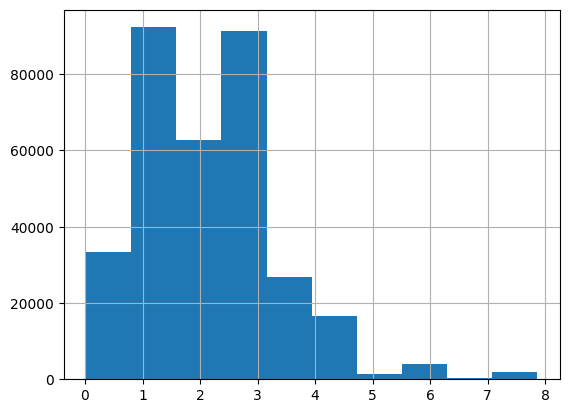

In [49]:
X_ann['distance'].hist()

In [50]:
X_train_ann,X_test_ann,y_train_ann,y_test_ann=train_test_split(X_ann,y_ann,random_state=42)

In [51]:
X_ann.shape

(330568, 5)

In [52]:
X_ann.sample()

,distance,destination,source,product_id,name
53720,4.48,Fenway,Financial District,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV


In [53]:
X_train_ann.shape

(247926, 5)

In [71]:
from tensorflow.keras.layers import Dense, Dropout

In [72]:

model = Sequential()

# Input + first hidden layer
model.add(Dense(64, activation='relu', input_shape=(33,)))
model.add(Dropout(0.3))   # Dropout 30%

# Second hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Third hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)


In [55]:
trf=ColumnTransformer([
    ('encode_destination',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False),[1]),
    ('encode_source',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False),[2]),
    ('encode_product_id',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False),[3]),
    ('encode_name',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False),[4]),
],remainder='passthrough')

In [56]:
X_train_ann=trf.fit_transform(X_train_ann)
X_test_ann=trf.transform(X_test_ann)

In [73]:
X_train_ann

array([[0.  , 1.  , 0.  , ..., 1.  , 0.  , 4.44],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 1.44],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 1.8 ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.56],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 2.8 ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.03]])

In [74]:
history=model.fit(X_train_ann,y_train_ann,epochs=10,validation_split=0.2)

Epoch 1/10
6199/6199 [==============================] - 12s 2ms/step - loss: 2.7974 - mae: 2.7974 - val_loss: 1.3846 - val_mae: 1.3846
Epoch 2/10
6199/6199 [==============================] - 11s 2ms/step - loss: 2.2608 - mae: 2.2608 - val_loss: 1.2388 - val_mae: 1.2388
Epoch 3/10
6199/6199 [==============================] - 11s 2ms/step - loss: 2.1026 - mae: 2.1026 - val_loss: 1.2284 - val_mae: 1.2284
Epoch 4/10
6199/6199 [==============================] - 11s 2ms/step - loss: 1.9995 - mae: 1.9995 - val_loss: 1.4106 - val_mae: 1.4106
Epoch 5/10
6199/6199 [==============================] - 11s 2ms/step - loss: 1.9599 - mae: 1.9599 - val_loss: 1.2610 - val_mae: 1.2610
Epoch 6/10
6199/6199 [==============================] - 11s 2ms/step - loss: 1.9251 - mae: 1.9251 - val_loss: 1.2095 - val_mae: 1.2095
Epoch 7/10
6199/6199 [==============================] - 11s 2ms/step - loss: 1.8960 - mae: 1.8960 - val_loss: 1.2172 - val_mae: 1.2172
Epoch 8/10
6199/6199 [==============================] -

In [59]:
y_pred_ann=model.predict(X_test_ann)
mean_absolute_percentage_error(y_test_ann,y_pred_ann)

2583/2583 [==============================] - 2s 915us/step


0.07682546728048519

In [60]:
y_pred_ann[:5]

array([[ 6.4021254],
       [ 6.8647738],
       [18.005686 ],
       [19.01727  ],
       [21.70143  ]], dtype=float32)

In [61]:
y_test_ann.head()

2255       5.5
159538     8.0
523077    18.5
119846    20.5
156332    23.5
Name: price, dtype: float64

In [62]:
print(f"Accuracy:{100-0.07696529131371008:.3f}%")

Accuracy:99.923%


In [63]:
history.history

{'loss': [1.6953057050704956,
  1.2236073017120361,
  1.205362319946289,
  1.1969372034072876,
  1.1897656917572021,
  1.183604121208191,
  1.1775579452514648,
  1.1733256578445435,
  1.1678589582443237,
  1.163949966430664],
 'val_loss': [1.238539218902588,
  1.230145812034607,
  1.2050037384033203,
  1.1905595064163208,
  1.1863987445831299,
  1.1823290586471558,
  1.1872936487197876,
  1.1904526948928833,
  1.2293550968170166,
  1.1848396062850952]}

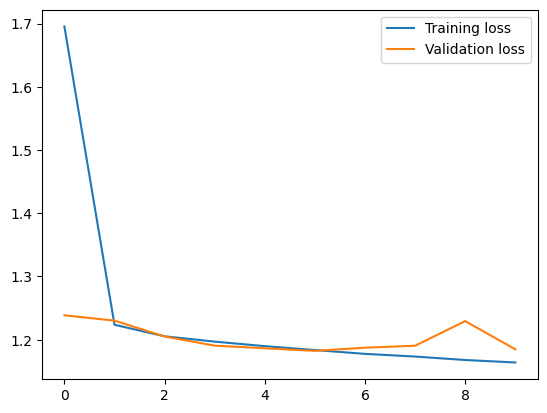

In [64]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [65]:
model.save('my_model.h5')

In [66]:
uber.sample()

,distance,destination,source,price,surge_multiplier,id,product_id,name
522466,4.72,Financial District,Boston University,39.5,1.0,2a82a080-20c3-4d54-9607-f3ed8e4167cc,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV
